## 1. Import libraries

In [2]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

In [3]:
import cv2 
import mediapipe as mp
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

In [4]:
EPOCHS = 100
RANDOM_SEED = np.random.seed(10)
BATCH_SIZE = 32

## 2. Initialize MediaPipe modules

In [5]:
mp_holistic = mp.solutions.holistic # Holistic model 
mp_drawing = mp.solutions.drawing_utils # Drawing utilities 
mp_face_mesh = mp.solutions.face_mesh

In [6]:
#     conda create -n my_gpu_env python=3.x
#     conda activate my_gpu_env

# conda install pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia
import torch
torch.cuda.is_available()

True

## 3. Define Helper

In [7]:
def mediapipe_detection(image, model): 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.setflags(write=False)         # Image is no longer writable
    results = model.process(image)      # Make prediction
    image.setflags(write=True)          # Image is now writable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results


## 4. Drawing Function

In [8]:
def draw_styled_landmarks(image, results):

    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_face_mesh.FACEMESH_CONTOURS,
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),  
                              mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                              )
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

## 5. Main Video Capturing Logic 
(show-no need for training)

In [9]:
# #Main function 
# cap = cv2.VideoCapture(0) 
# # Set mediapipe model  
# with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic: 
#     while cap.isOpened(): 
  
#         # Read feed 
#         ret, frame = cap.read() 
  
#         # Make detections 
#         image, results = mediapipe_detection(frame, holistic) 
#         print(results) 
          
#         # Draw landmarks 
#         draw_styled_landmarks(image, results) 
  
#         # Show to screen 
#         cv2.imshow('Holistic Model Output', image) 
  
#         # Break gracefully 
#         if cv2.waitKey(10) & 0xFF == ord('q'): 
#             break
#     cap.release() 
#     cv2.destroyAllWindows()

## 6. Extract Keypoint Values 
(x,y,z values from detected body + store in numpy arr or "0")

In [10]:
#same logic as above but in function, so can be used
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh]) # flatten arr of points x,y,z visibility values - single vector

## 7. Setup Folders for Collection

In [11]:
DATA_PATH = os.path.join('MP_Data_Emotions') 
emotions = np.array([
    'happy',
    'sad',
    'angry',
    'surprise',
    'fear',
    'disgust',
    'neutral'
])
samples_per_emotion = 50

no need to rerun

In [11]:
for emotion in emotions: 
    os.makedirs(os.path.join(DATA_PATH, emotion), exist_ok = True)

## 8. Collect Keypoint Values for Training and Testing
no need to re-run (have collected)

In [12]:
import time

cap = cv2.VideoCapture(0)
stop = False

SAVE_DELAY = 2   # seconds between saved samples

with mp_holistic.Holistic(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
) as holistic:

    for emotion in emotions:

        sample_count = 0

        print(f"STARTING COLLECTION for {emotion}")
        print("Prepare expression...")

        time.sleep(5)

        last_save_time = 0

        while sample_count < samples_per_emotion:

            ret, frame = cap.read()
            if not ret:
                break

            image, results = mediapipe_detection(frame, holistic)
            draw_styled_landmarks(image, results)

            current_time = time.time()
            time_left = SAVE_DELAY - (current_time - last_save_time)

            # UI TEXT
            if time_left > 0:
                cv2.putText(
                    image,
                    f'Next capture in: {time_left:.1f}s',
                    (10,60),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.8,
                    (0,255,255),
                    2
                )

            cv2.putText(
                image,
                f'Collecting: {emotion} [{sample_count}/{samples_per_emotion}]',
                (10,30),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.8,
                (0,255,0),
                2
            )

            cv2.imshow("Emotion Collection", image)

            # SAVE ONLY every 2 seconds
            if results.face_landmarks and (current_time - last_save_time >= SAVE_DELAY):

                keypoints = extract_keypoints(results)

                np.save(
                    os.path.join(DATA_PATH, emotion, str(sample_count)),
                    keypoints
                )

                sample_count += 1
                last_save_time = current_time

                print(f"Saved sample {sample_count}")

            if cv2.waitKey(1) & 0xFF == ord('q'):
                stop = True
                break

        if stop:
            break

cap.release()
cv2.destroyAllWindows()


STARTING COLLECTION for happy
Prepare expression...
Saved sample 1
Saved sample 2
Saved sample 3
Saved sample 4
Saved sample 5
Saved sample 6
Saved sample 7
Saved sample 8
Saved sample 9
Saved sample 10
Saved sample 11
Saved sample 12
Saved sample 13
Saved sample 14
Saved sample 15
Saved sample 16
Saved sample 17
Saved sample 18
Saved sample 19
Saved sample 20
Saved sample 21
Saved sample 22
Saved sample 23
Saved sample 24
Saved sample 25
Saved sample 26
Saved sample 27
Saved sample 28
Saved sample 29
Saved sample 30
Saved sample 31
Saved sample 32
Saved sample 33
Saved sample 34
Saved sample 35
Saved sample 36
Saved sample 37
Saved sample 38
Saved sample 39
Saved sample 40
Saved sample 41
Saved sample 42
Saved sample 43
Saved sample 44
Saved sample 45
Saved sample 46
Saved sample 47
Saved sample 48
Saved sample 49
Saved sample 50
STARTING COLLECTION for sad
Prepare expression...
Saved sample 1
Saved sample 2
Saved sample 3
Saved sample 4
Saved sample 5
Saved sample 6
Saved sample 7
Sa

## 9. Preprocess Data and Create Labels and Features

In [26]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical # to one-hot encoding data

In [12]:
label_map = {label:num for num, label in enumerate(emotions)}
# label dictionary to represent each one of our action

In [13]:
label_map

{np.str_('happy'): 0,
 np.str_('sad'): 1,
 np.str_('angry'): 2,
 np.str_('surprise'): 3,
 np.str_('fear'): 4,
 np.str_('disgust'): 5,
 np.str_('neutral'): 6}

In [22]:
features, labels = [], [] #x, y data
for emotion in emotions:
    for i in range(samples_per_emotion):
        samples = np.load(os.path.join(DATA_PATH, emotion, "{}.npy".format(i)))
        features.append(samples)
        labels.append(label_map[emotion])

## With augmentation

In [23]:
def emotion_augment(kp, prob=0.5):

    if np.random.rand() > prob:
        return kp.copy()

    kp = kp.copy().reshape(-1, 3)

    # Rotation
    rot_deg = np.random.uniform(-5, 5)
    rad = np.radians(rot_deg)

    rot = np.array([
        [np.cos(rad), -np.sin(rad)],
        [np.sin(rad),  np.cos(rad)]
    ])

    kp[:, :2] = kp[:, :2] @ rot.T

    # Scale
    kp[:, :2] *= np.random.uniform(0.97, 1.03)

    # Shift
    kp[:, :2] += np.random.uniform(-0.02, 0.02, (1,2))

    # Noise
    kp += np.random.normal(0, 0.003, kp.shape)

    return kp.reshape(-1)

In [24]:
features = []
labels = []

for emotion in emotions:
    for i in range(samples_per_emotion):

        sample = np.load(os.path.join(DATA_PATH, emotion, f"{i}.npy"))

        # ORIGINAL
        features.append(sample)
        labels.append(label_map[emotion])

        # AUGMENTED
        aug = emotion_augment(sample)
        features.append(aug)
        labels.append(label_map[emotion])

In [27]:
X = np.array(features).astype("float32")
y = to_categorical(labels)
# y = to_categorical(labels).astype(int) #to 1 hot encoding

In [28]:
X.shape

(700, 1662)

In [29]:
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], shape=(700, 7))

In [30]:
from sklearn.model_selection import train_test_split

# Train + temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.15,
    stratify=y,
    random_state=42
)

# Val + Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)

Train: (595, 1662)
Val: (52, 1662)
Test: (53, 1662)


In [23]:
# X_train.shape

In [24]:
# y_test.shape

## 10. Build and Train LSTM Neural Network

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard #to monitor model as its training
from sklearn.model_selection import KFold, GroupKFold
from tensorflow.keras.regularizers import l2

In [32]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

## Simplify Model

In [33]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
# # es_callback = EarlyStopping(monitor='val_categorical_accuracy', patience=100, restore_best_weights=True, verbose=1)
rp_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=1e-5, verbose=1)

In [19]:
model = Sequential([
    Dense(512, activation='relu', input_shape=(1662,)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(len(emotions), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

c:\Users\User\anaconda3\envs\cuda\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       851,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,019,655 (3.89 MB)

 Trainable params: 1,018,119 (3.88 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [32]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[rp_callback, tb_callback]
)


Epoch 1/100


c:\Users\User\anaconda3\envs\cuda\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4504 - loss: 1.5523 - val_accuracy: 0.1346 - val_loss: 5.2382 - learning_rate: 0.0010
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6538 - loss: 1.0111 - val_accuracy: 0.1923 - val_loss: 5.4431 - learning_rate: 0.0010
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.6891 - loss: 0.8948 - val_accuracy: 0.1538 - val_loss: 5.3400 - learning_rate: 0.0010
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7345 - loss: 0.8037 - val_accuracy: 0.1538 - val_loss: 3.7882 - learning_rate: 0.0010
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7193 - loss: 0.8238 - val_accuracy: 0.2885 - val_loss: 3.0791 - learning_rate: 0.0010
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7311 - loss: 0.7158 - val_accuracy: 0.1923 - val_loss: 2.2396 - learning_rate: 0.0010
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.7630 - loss: 0.6668 - val_accuracy

categorical_crossentropy -> multi-class classification

binary_crossentropy -> binary-class classification

MSE -> regressions

In Terminal move to Logs/train: 

tensorboard --logdir=. (to see logs)

In [ ]:
# tensorboard --logdir=. 
# to see logdir

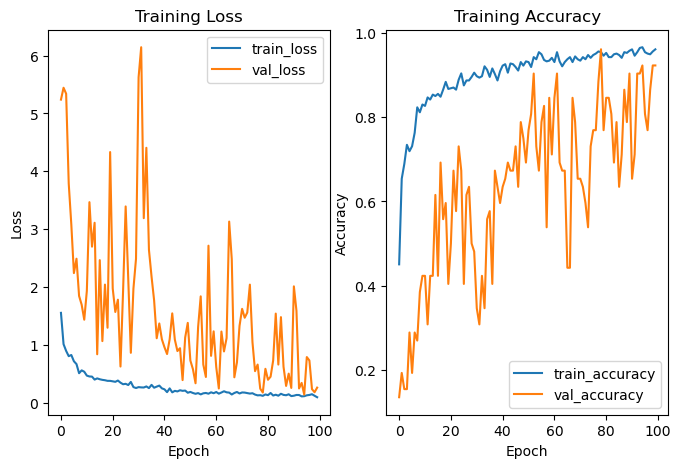

In [34]:
plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [35]:
loss, acc = model.evaluate(X_test, y_test)
print("Test accuracy:", acc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9245 - loss: 0.2076
Test accuracy: 0.9245283007621765


c:\Users\User\anaconda3\envs\cuda\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


## 11. Make Predictions

In [36]:
res = model.predict(X)
# res = model.predict(X_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [37]:
emotions[np.argmax(res[1])] #train data val

np.str_('happy')

In [38]:
emotions[np.argmax(y[1])] #pred of model
# actions[np.argmax(y_test[1])] #pred of model

np.str_('happy')

## 12. Save Model and Load Weights

In [39]:
model.save('emotions_own.h5')

In [34]:
model.load_weights('emotions_own.h5')

# 13. Evaluation using Confusion Matrix and Accuracy


In [35]:
yhat = model.predict(X)
# yhat = model.predict(X_test)

# axis=1 -> want to convert second dim in the arr
# ytrue = np.argmax(y_test, axis=1).tolist()
ytrue = np.argmax(y, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist() # numbers of classes

12/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

c:\Users\User\anaconda3\envs\cuda\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [36]:

from sklearn.metrics import accuracy_score
accuracy_score(ytrue, yhat)

0.9457142857142857

# 14. Test in Real Time

In [37]:
# f to render probabilities
colors = [(245,117,16), (117,245,16), (16,117,245), (255,0,0), (255,255,0), (0,255,255), (128,128,128)]
# color combo for each emotion: happy, sad, angry, surprise, fear, disgust, neutral
def prob_viz(res, emotions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40),
                    (int(prob*100), 90+num*40),
                    colors[num], -1
        ) 
        # bar dynamically changes based on probability (longer = higher)
        cv2.putText(
            output_frame, emotions[num],
            (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX,
            1, (255,255,255),
            2, cv2.LINE_AA)
        
    return output_frame

# 15. Real time test

In [38]:
# 1. New detection variables
current_emotion = ""
predictions = []
threshold = 0.4

cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
) as holistic:

    while cap.isOpened():

        ret, frame = cap.read()
        if not ret:
            break

        image, results = mediapipe_detection(frame, holistic)
        draw_styled_landmarks(image, results)

        if results.face_landmarks:

            keypoints = extract_keypoints(results)

            res = model.predict(
                np.expand_dims(keypoints, axis=0),
                verbose=0
            )[0]

            pred_class = np.argmax(res)
            predictions.append(pred_class)

            # --- smoothing ---
            if len(predictions) > 10:
                predictions = predictions[-10:]

            if predictions.count(pred_class) > 6:
                if res[pred_class] > threshold:
                    current_emotion = emotions[pred_class]

            # Viz probabilities
            image = prob_viz(res, emotions, image, colors)

        # TOP BAR
        cv2.rectangle(image, (0,0), (640,40), (245,117,16), -1)

        cv2.putText(
            image,
            current_emotion,
            (10,30),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (255,255,255),
            2,
            cv2.LINE_AA
        )

        cv2.imshow("Emotion Test", image)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

c:\Users\User\anaconda3\envs\cuda\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
